In [3]:
import os

path = "/home/marta/Documenti/eeg-ml-thesis/"
os.chdir(path)

import torch 
import torch.nn as nn 
import torch.nn.functional as F
import torch.optim as optim 
from torch.utils.data import Dataset, DataLoader, Subset
import numpy as np 
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import r_pca 
import scipy.io
from tqdm import tqdm
import datetime 
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay 
import matplotlib.pyplot as plt


### Parameters

In [4]:
DATASET_DIR = "/home/marta/Documenti/eeg_rnn_repo/rnn-eeg-ad/eeg2"
WINDOW = 256
OVERLAP = WINDOW // 2 
subj_list = (
    tuple((f'{i:02d}', 'N') for i in range(1, 16)) +  # normal subjects, S01 to S15
    tuple((f'{i:02d}', 'AD') for i in range(1, 21))   # alzheimer's subjects, S01 to S20
)

input_dim = 16        
hidden_dim = 8        
output_dim = 2    
window_size = 20      
dropout_prob = 0.5 
device = torch.device("cuda")

subjs_test = (0, 1, 15, 16, 17)  
test_subject_list = [subj_list[i] for i in subjs_test]
train_val_subjects = [subj for i, subj in enumerate(subj_list) if i not in subjs_test]   

### Copute Crops

In [5]:

def precompute_crops(subject_list, window, overlap, num_columns=16, train_dataset=None):
    

    if train_dataset == True:
        save_dir = "/home/marta/Documenti/eeg-ml-thesis/alessandrini-train"
        os.makedirs(save_dir, exist_ok=True)
    elif train_dataset == False:
        save_dir = "/home/marta/Documenti/eeg-ml-thesis/alessandrini-test"
        os.makedirs(save_dir, exist_ok=True)

    for subject_id, category_label in subject_list:
        file_path = f"{DATASET_DIR}/S{subject_id}_{category_label}.npz"
        save_path = f"{save_dir}/S{subject_id}_{category_label}_crops.npz"

        # if os.path.exists(save_path): 
        #    print(f"Skipping {subject_id}, crops already exist.")
        #    continue

        eeg = np.load(file_path)['eeg'].T 

        scaler = StandardScaler()
        eeg = scaler.fit_transform(eeg)

        num_windows = (len(eeg) - window) // (window - overlap) + 1
        x_data = np.empty((num_windows, window, num_columns))

        i = 0
        for w in range(num_windows):
            x_data[w] = eeg[i:i + window]
            i += (window - overlap)

        y_data = np.full((num_windows, 1), (category_label == 'AD')) 

        np.savez(save_path, x_data=x_data, y_data=y_data)
        # print(f"Saved crops for {subject_id} at {save_path}")


precompute_crops(train_val_subjects, window=WINDOW, overlap=OVERLAP, train_dataset=True)
precompute_crops(test_subject_list, window=WINDOW, overlap=OVERLAP, train_dataset=False)

### PCA Functions

In [6]:
def split_train_val(dataset, test_size=0.2, random_state=42):
    train_indices, val_indices = train_test_split(
        range(len(dataset.crops_index)), 
        test_size=test_size,
        random_state=random_state
    )
    return train_indices, val_indices 

def pca_reduction(A, tol, comp = 0):
  rpca = False
  rpca_mu = 0
  multiscale_pca = False

  assert(len(A.shape) == 2)
  dmin = min(A.shape)
  if rpca:
    r = r_pca.R_pca(A, mu = rpca_mu)
    print('Auto tol:', 1e-7 * r.frobenius_norm(r.D), 'used tol:', tol)
    print('mu', r.mu, 'lambda', r.lmbda)
    L, S = r.fit(tol = tol, max_iter = 10, iter_print = 1)
    global norm_s
    norm_s = np.linalg.norm(S, ord='fro')  # for debug
    print('||A,L,S||:', np.linalg.norm(A, ord='fro'), np.linalg.norm(L, ord='fro'), np.linalg.norm(S, ord='fro'))
    #np.savez_compressed('rpca.npz', pre = A, post = L)
  elif multiscale_pca:
    print('MSPCA...')
    #ms = mspca.MultiscalePCA()
    #L = ms.fit_transform(A, wavelet_func='sym4', threshold=0.1, scale = True )
    print('saving MAT file and calling Matlab...')
    scipy.io.savemat('mspca.mat', {'A': A}, do_compression = True)
    os.system('matlab -batch "mspca(\'mspca.mat\')"')
    L = scipy.io.loadmat('mspca.mat')['L'] 
  else:
    
    L = A
  U, lam, V = np.linalg.svd(L, full_matrices = False)  # V is transposed
  assert(U.shape == (A.shape[0], dmin) and lam.shape == (dmin,) and V.shape == (dmin, A.shape[1]))
  #np.savetxt('singular_values.csv', lam)
  lam_trunc = lam[lam > 0.015 * lam[0]]  # magic number
  p = comp if comp else len(lam_trunc)
  assert(p <= dmin)
  #print('PCA truncation', dmin, '->', p)
  return L, V.T[:,:p]

def reduce_matrix(A, V):
  # (N, w, 16) → (N, 16, w) → ((N*16), w) → compute V
  # (N, 16, w) * V → transpose again last dimensions
  B = np.swapaxes(A, 1, 2)  # (N, 16, w)
  C = B.reshape((-1, B.shape[2]))  # ((N*16), w)
  if V is None:
    L, V = pca_reduction(C, 5e-6, comp = 50)
  B = C @ V  # ((N*16), p)
  B = B.reshape((A.shape[0], A.shape[2], B.shape[1]))  # (N, 16, p)
  return np.swapaxes(B, 1, 2), V  # B = (N, p, 16)

def adjust_size(x, y):
  # when flattening the data matrix on the first dimension, y must be made compatible
  if len(x) == len(y): return y
  factor = len(x) // len(y)
  ynew = np.empty((len(x), 1))
  for i in range(0, len(y)):
    ynew[i * factor : (i + 1) * factor] = y[i]
  return ynew


### Oversampling

Oversampling only on trainig dataset

In [7]:
def oversampling(x_data, y_data, num_classes=2):
  # Duplicate inputs with classes occurring less, so to have a more balanced distribution.
  # It operates on single data windows, so use it on data that have already been split
  #  by subject (typically only on training data).
  x_data_over = x_data.copy()
  y_data_over = y_data.copy()
  occurr = [np.sum(y_data == cl) for cl in range(0, num_classes)]
  for cl in range(0, num_classes):
    if occurr[cl] == max(occurr):
      continue
    mask = y_data[:, 0] == cl
    x_dup = x_data[mask].copy()
    y_dup = y_data[mask].copy()
    while occurr[cl] < max(occurr):
      x_dup_jitter = x_dup + np.random.normal(scale=0.03, size=x_dup.shape)
      how_many = min(len(y_dup), max(occurr) - occurr[cl])
      x_data_over = np.vstack((x_data_over, x_dup_jitter[:how_many]))
      y_data_over = np.vstack((y_data_over, y_dup[:how_many]))
      occurr[cl] += how_many
  return x_data_over, y_data_over

In [8]:
path = "/home/marta/Documenti/eeg-ml-thesis/alessandrini-train"

x_all = []
y_all = []

for file in os.listdir(path):
    if file.endswith(".npz"):  
        file_path = os.path.join(path, file)
        data = np.load(file_path)
        
        x_all.append(data['x_data'])  
        y_all.append(data['y_data'])  

x_all = np.vstack(x_all)  
y_all = np.vstack(y_all)

print(f"Original dataset size: {x_all.shape}, Labels distribution: {np.bincount(y_all.flatten())}")

x_all_over, y_all_over = oversampling(x_all, y_all)

print(f"Oversampled dataset size: {x_all_over.shape}, Labels distribution: {np.bincount(y_all_over.flatten())}")

x_all_over = torch.tensor(x_all_over).float()
y_all_over = torch.tensor(y_all_over).float()

Original dataset size: (40602, 256, 16), Labels distribution: [16290 24312]
Oversampled dataset size: (48624, 256, 16), Labels distribution: [24312 24312]


### Train test split and apply PCA
- dovrei poter testare anche per diversi parametri di PCA

In [9]:
x_data_train, x_data_val, y_data_train, y_data_val = train_test_split(x_all_over, y_all_over, train_size = 0.75, random_state=42, shuffle=True)

print(f"training data shape: {x_data_train.shape}")
print(f"training data shape: {y_data_train.shape}")
print(f"validation data shape: {x_data_val.shape}")
print(f"validation data shape: {y_data_val.shape}")

training data shape: torch.Size([36468, 256, 16])
training data shape: torch.Size([36468, 1])
validation data shape: torch.Size([12156, 256, 16])
validation data shape: torch.Size([12156, 1])


In [10]:
x_data_train, Vpca = reduce_matrix(x_data_train, None)
y_data_train = adjust_size(x_data_train, y_data_train)

x_data_val, _ = reduce_matrix(x_data_val, Vpca)
y_data_val = adjust_size(x_data_val, y_data_val)

print(f"training data shape: {x_data_train.shape}")
print(f"training data shape: {y_data_train.shape}")
print(f"validation data shape: {x_data_val.shape}")
print(f"validation data shape: {y_data_val.shape}")

training data shape: torch.Size([36468, 50, 16])
training data shape: torch.Size([36468, 1])
validation data shape: torch.Size([12156, 50, 16])
validation data shape: torch.Size([12156, 1])


### Dataset and Dataloader

In [11]:
class AlessandriniEegDataset(Dataset):
    def __init__(self, x_data, y_data):
        self.x_data = x_data
        self.y_data = y_data

    def __len__(self):
        return len(self.x_data)

    def __getitem__(self, idx):
        return self.x_data[idx], self.y_data[idx]

train_dataset = AlessandriniEegDataset(x_data_train, y_data_train)
val_dataset = AlessandriniEegDataset(x_data_val, y_data_val)
test_dataset = AlessandriniEegDataset(x_data_val, y_data_val)

#train_indices, val_indices = split_train_val(dataset_over, test_size=0.2)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=True)

### RNN model

In [10]:
class LSTMModel(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim, num_layers=1, dropout_prob=0.5):
        super(LSTMModel, self).__init__()
        
        ##TODO aggiungere un layer di flatten per processare la sequenza in maniera temporale 
        self.lstm1 = nn.LSTM(input_dim, hidden_dim, num_layers=num_layers, batch_first=True)
        
        self.dropout1 = nn.Dropout(dropout_prob)
        
        self.lstm2 = nn.LSTM(hidden_dim, hidden_dim, num_layers=num_layers, batch_first=True)
        
        self.dropout2 = nn.Dropout(dropout_prob)
        
        self.fc = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        # layer di attivazione
        
        # x = x.squeeze(0)  
        out, (hn, cn) = self.lstm1(x)
        
        out = self.dropout1(out)
        
        out, (hn, cn) = self.lstm2(out)
        
        out = self.dropout2(out[:, -1, :])  
        
        out = self.fc(out)
        
        # out = F.log_softmax(out, dim=1) uso la loss cross entropy
        
        return out

In [12]:
class LSTMModel(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim, num_layers=1, dropout_prob=0.5, use_dense1=False):
        super(LSTMModel, self).__init__()
        
        # Optional Dense Layer Before LSTM (matches TensorFlow's `dense1`)
        self.use_dense1 = use_dense1
        if use_dense1:
            self.dense1 = nn.Linear(input_dim, hidden_dim)
        
        # First LSTM Layer (returns full sequence if second LSTM exists)
        self.lstm1 = nn.LSTM(hidden_dim if use_dense1 else input_dim, hidden_dim, num_layers=num_layers, 
                             batch_first=True, dropout=dropout_prob if num_layers > 1 else 0, 
                             bidirectional=False)

        self.dropout1 = nn.Dropout(dropout_prob) 

        # Second LSTM Layer (if present, returns last output)
        self.lstm2 = nn.LSTM(hidden_dim, hidden_dim, num_layers=num_layers, batch_first=True, 
                             dropout=dropout_prob if num_layers > 1 else 0) 

        self.dropout2 = nn.Dropout(dropout_prob)

        # Fully Connected Output Layer (No Softmax, since CrossEntropyLoss expects logits)
        self.fc = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        if self.use_dense1:
            x = self.dense1(x)
        
        # First LSTM layer
        out, _ = self.lstm1(x)
        out = self.dropout1(out)

        # Second LSTM layer (keeps last output only)
        out, _ = self.lstm2(out)
        out = self.dropout2(out[:, -1, :])  # Keep only last timestep
        
        # Fully connected output
        out = self.fc(out)
        
        return out  # No softmax, since PyTorch's CrossEntropyLoss applies it


### Training functions

In [31]:
def calculate_accuracy(y_pred, y_true):
  
  correct = (y_pred == y_true).sum().item()
  
  return correct / y_true.size(0)


In [38]:
def train(model, device, train_loader, optimizer, epoch):
  print("starting training loop")
  
  """
  Define Training Step
  """
  
  model.train()
  
  train_loss = 0.0
  pred_list = []
  gt_list = []
  
  
  for batch_idx, (data, target) in enumerate(tqdm(train_loader)):

    data, target = data.to(device), target.to(device)
    
    optimizer.zero_grad()
    output = model(data)
    

    target = target.squeeze().long()

    
    criterion = nn.CrossEntropyLoss()
    loss = criterion(output, target)
    train_loss += loss.item()
    loss.backward()
    optimizer.step()
    
    _, y_pred = torch.max(output,1)
    
    pred_list.append(y_pred)
    gt_list.append(target)
    
  pred_list = torch.cat(pred_list)
  gt_list = torch.cat(gt_list)
  
  train_acc = calculate_accuracy(pred_list, gt_list) 
  print("ended training step")
  return train_loss / len(train_loader), train_acc, pred_list, gt_list 

def validation(model, device, val_loader):
  print("starting validation step")
  
  """
  Define Validation Step
  """
    
  model.eval()
  
  val_loss = 0   
  pred_list = []
  gt_list = []

  criterion = nn.CrossEntropyLoss()
  
  with torch.no_grad():
    
    for data, target in val_loader:
        
      data, target = data.to(device), target.to(device).squeeze().long()
      output = model(data)
      loss = criterion(output, target)
      val_loss += loss.item()
      _, y_pred = torch.max(output,1)
      
      pred_list.append(y_pred)
      gt_list.append(target)
      # correct += pred.eq(target.view_as(pred)).sum().item()
      
  pred_list = torch.cat(pred_list)
  gt_list = torch.cat(gt_list)
           
  val_acc = calculate_accuracy(pred_list, gt_list)
  
  
  return val_loss / len(val_loader.dataset), val_acc, pred_list, gt_list 
     

def test_and_save_confusion_matrix(model, device, loader):
    model.eval()
    gt_list = []
    pred_list = []
    
    with torch.no_grad():
        for data, target in loader:
            data, target = data.to(device), target.to(device).squeeze().long()
            output = model(data)
            _, y_pred = torch.max(output, 1)  
            
            pred_list.append(y_pred)
            gt_list.append(target)
            
        pred_list = torch.cat(pred_list)
        gt_list = torch.cat(gt_list)
        
    print(pred_list)
    print(gt_list)
    test_acc = calculate_accuracy(pred_list, gt_list)
    print(f"Test Accuracy: {test_acc:.2f}%")    
    # Compute confusion matrix
    cm = confusion_matrix(gt_list.cpu().numpy(), pred_list.cpu().numpy())
    num_classes = cm.shape[0]
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=np.arange(num_classes))

    # Plot and save confusion matrix
    disp.plot(cmap='viridis')
    plt.title('Confusion Matrix')
    plt.savefig('output/confusion_matrix.png')
    plt.show()   
         
def save_model(model, optimizer, epoch):
    """
    Function to save model states for a given epoch.
    """
    
    model_name = model.__class__.__name__

    model_dir = os.path.join(os.getcwd(), "output")
    os.makedirs(model_dir, exist_ok=True)  # Creates directory if it doesn't exist

    # Generate filename with timestamp
    now = datetime.datetime.now().strftime('%Y%m%d_%H%M%S')
    path = os.path.join(model_dir, f"{model_name}_{now}.pth")  # Add `.pth` for clarity

    torch.save({
        'epoch': epoch,
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
    }, path)

    print(f"Model saved to {path}")



### Training loop

In [33]:
model = LSTMModel(input_dim, hidden_dim, output_dim, dropout_prob=dropout_prob, use_dense1=False)

model = model.to(device)

optimizer = optim.Adam(model.parameters(), lr=0.001, betas=(0.9, 0.999))
# scheduler = StepLR(optimizer, step_size=1)
num_epochs = 2
for epoch in range(1, num_epochs):
  print(f"Processing epoch number: {epoch}")
  train_loss, train_acc, train_preds, train_gts = train(model=model, device=device, train_loader=train_loader, optimizer=optimizer, epoch=epoch)

  print(f"train_preds: {train_preds}")
  print(f"train_gts {train_gts}")
  print(f"training accuracy: {train_acc}")

  val_loss, val_acc, val_preds, val_gts = validation(model, device, val_loader)
  print(f"train_preds: {val_preds}")
  print(f"train_gts {val_gts}")
  print(f"validation accuracy: {val_acc}")
  
  save_model(model, optimizer, epoch)  


Processing epoch number: 1
starting training loop


  0%|          | 0/1140 [00:00<?, ?it/s]

100%|██████████| 1140/1140 [00:07<00:00, 153.57it/s]


ended training step
train_preds: tensor([0, 0, 0,  ..., 1, 1, 0], device='cuda:0')
train_gts tensor([0, 1, 0,  ..., 1, 1, 0], device='cuda:0')
training accuracy: 0.563864209718109
starting validation step
train_preds: tensor([0, 1, 0,  ..., 1, 0, 0], device='cuda:0')
train_gts tensor([1, 1, 0,  ..., 1, 0, 0], device='cuda:0')
validation accuracy: 0.7639848634419217
Model saved to /home/marta/Documenti/eeg-ml-thesis/output/LSTMModel_20250223_163814.pth


### Testing

In [21]:
path = "/home/marta/Documenti/eeg-ml-thesis/alessandrini-test"

x_test_all = []
y_test_all = []

for file in os.listdir(path):
    if file.endswith(".npz"):  
        file_path = os.path.join(path, file)
        data = np.load(file_path)
        
        x_test_all.append(data['x_data'])  
        y_test_all.append(data['y_data'])  

x_test_all = np.vstack(x_test_all)
y_test_all = np.vstack(y_test_all)


x_data_test, _ = reduce_matrix(x_test_all, Vpca.cpu().numpy() if isinstance(Vpca, torch.Tensor) else Vpca)

y_data_test = adjust_size(x_data_test, y_test_all)

In [35]:
def test_and_save_confusion_matrix(model, device, loader):
    model.eval()
    gt_list = []
    pred_list = []
    
    with torch.no_grad():
        for data, target in loader:
            data, target = data.to(device), target.to(device).squeeze().long()
            output = model(data)
            _, y_pred = torch.max(output, 1)  
            
            pred_list.append(y_pred)
            gt_list.append(target)
            
        pred_list = torch.cat(pred_list)
        gt_list = torch.cat(gt_list)
        
    print(pred_list)
    print(gt_list)
    test_acc = calculate_accuracy(pred_list, gt_list)
    print(f"Test Accuracy: {test_acc:.2f}%") 
  

test_and_save_confusion_matrix(model, device, test_loader) 


tensor([0, 1, 1,  ..., 1, 1, 1], device='cuda:0')
tensor([0, 1, 1,  ..., 1, 0, 1], device='cuda:0')
Test Accuracy: 0.93%


tensor([1, 1, 0,  ..., 0, 1, 0], device='cuda:0')
tensor([1, 1, 0,  ..., 0, 1, 0], device='cuda:0')
Test Accuracy: 0.93%


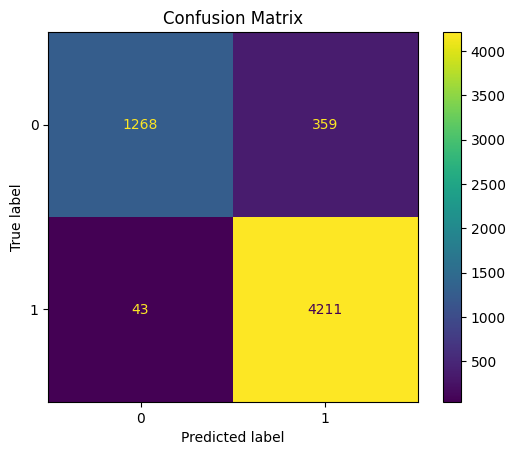

In [39]:
x_data_test = x_data_test.astype(np.float32)  

test_dataset = AlessandriniEegDataset(x_data_test, y_data_test)

test_loader = DataLoader(test_dataset, batch_size=32, shuffle=True)

test_and_save_confusion_matrix(model, device, test_loader) 